# load lib

In [1]:
import tensorflow as tf
#--------------------------------------
print(tf.__version__)
import random
random.seed(43)


print(tf.config.list_physical_devices('GPU'))
from tensorflow.compat.v1.keras import backend as K
config =  tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = .5
config.gpu_options.allow_growth = True
sess =  tf.compat.v1.Session(config=config)
K.set_session(sess)
tf.compat.v1.reset_default_graph()

from albumentations import OneOf, HorizontalFlip, VerticalFlip
from albumentations.augmentations.transforms import Rotate

from skimage.transform import resize

from tensorflow.keras import backend as k
from tensorflow.keras.layers import Dense, Conv2D, add, BatchNormalization, Dropout, Flatten, Reshape, LeakyReLU
from tensorflow.keras.models import Model 
import cv2
import numpy as np
import pandas as pd
import os
from PIL import Image
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from classification_models.tfkeras import Classifiers
import datetime
from livelossplot import PlotLossesKeras

import matplotlib.pyplot as plt
from focal_loss import SparseCategoricalFocalLoss
from focal_loss import BinaryFocalLoss

2.3.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# load data 

In [ ]:
valid = pd.read_csv('valid_new.csv')
train=pd.read_csv('trainAug.csv')
valid.rename(columns = {'Age':'age'}, inplace = True) 
valid.rename(columns = {'Race':'race'}, inplace = True) 
valid.rename(columns = {'Gender':'gender'}, inplace = True) 
valid.rename(columns = {'file_name':'img_path'}, inplace = True) 

no_race_classes = train.race.unique().size

q1, q3 = train.age.quantile([0.25,0.75]).to_list()
iqr = q3-q1
train.age = (train.age - q1)/iqr
valid.age = (valid.age - q1)/iqr

print('train',len(train))
print('valid',len(valid))


valid.img_path = '../UTKfaceCut/'+ valid.img_path



   
    

In [ ]:
import os
valid = valid.reset_index(drop=True)
train = train.reset_index(drop=True)

for i in range(len(valid)):
    if not os.path.exists(valid['img_path'][i]):
        valid.drop(valid.loc[valid['img_path']==valid['img_path'][i]].index, inplace=True)
        #print(valid['img_path'][i])

for i in range(len(train)):
    if not os.path.exists(train['img_path'][i]):
        train.drop(train.loc[train['img_path']==train['img_path'][i]].index, inplace=True)
        #print(valid['img_path'][i])        
        
        


In [ ]:
valid = valid.reset_index(drop=True)
train = train.reset_index(drop=True)
train

# data data generator during train

In [ ]:
def gen(df, batch_size = 100, w=224, h=224):
    df = df.reset_index(drop=True)
    augmenter = OneOf([HorizontalFlip(p = 0.5), VerticalFlip(p = 0.5),Rotate(p=0.5,limit=90)], p = 0.6)
    while True:
        samples_range = len(df)//batch_size
        for i in range(samples_range) :
            start = i * batch_size
            end = start + batch_size
            y = [np.array(df['age'].loc[start:end-1]),
                 np.array(df['gender'].loc[start:end-1]),
                 np.array(df['race'].loc[start:end-1])]
            x =[]
            for j in range (start, end):
                try :
                    
                    img = cv2.imread(df.loc[j]['img_path'],cv2.IMREAD_COLOR)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img =cv2.resize(img, (w,h))
                    aug_dict = augmenter(image = img)
                    img = aug_dict['image']
                    x.append(img)
                except :
                    print(df.loc[j]['img_path'])
                    pass
            x = np.array(x)/255
            yield x, y
            
# g_train = gen(train, batch_size = 128)
           
# for i in range(int(len(train)/128)):
#     x, y = next(g_train)             


# data data generator during evalutate

In [ ]:
def genv(df, batch_size = 100, w=299, h=299):
    df = df.reset_index()
    while True:
        samples_range = len(df)//batch_size
        for i in range(samples_range) :
            start = i * batch_size
            end = start + batch_size
            y = [
                np.array(df['age'].loc[start:end-1]), 
                np.array(df['gender'].loc[start:end-1]), 
                np.array(df['race'].loc[start:end-1])
              ]
            x =[]
            for j in range (start, end):
                try :
                    img = cv2.imread(df.loc[j]['img_path'],cv2.IMREAD_COLOR)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255
                    img =cv2.resize(img, (w,h) )
                except :
                    print(df.loc[j]['img_path'])
                    pass
            x = np.array(x)
            yield x, y




In [ ]:
g_train = gen(train, batch_size = 20)
x, y = next(g_train) 
x, y = next(g_train) 
x, y = next(g_train) 

x.shape

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(0, n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x[i])
    ax.text(0.95, 0.01, '{}, {}, {}'.format(np.round((y[0][i]),3), y[1][i], y[2][i]), style='italic',
    bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 1})

    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# trainable_weights

In [ ]:
def trainable_weights(model):
    print("weights:", len(model.weights))
    print("trainable_weights:", len(model.trainable_weights))
    print("non_trainable_weights:", len(model.non_trainable_weights))

# callbacks

In [ ]:
def loss_apt_callbacks(lr,model,cost,metric, loss_weights, RUN_NAME,pa_estop=20,pa_Reduce=5):
    
    plotlosses = PlotLossesKeras()

    ReduceLROnPlateau =tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=pa_Reduce, mode='min',min_delta=0.00001)  

    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join('..','logs','models','{}.h5'.format(RUN_NAME)), save_best_only=True, verbose=1,mode='min') 

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.0001, patience=pa_estop, restore_best_weights=True)

    callbacks = [plotlosses,early_stopping, checkpoint,ReduceLROnPlateau]

    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=opt, loss=cost, metrics=metric,loss_weights=loss_weights)
    
    
    return model,callbacks

# loss function

In [ ]:
###LOSSES
# def focal_loss(y_true, y_pred, gamma=2., alpha=.25):
#     pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
#     pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
#     return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

from focal_loss import BinaryFocalLoss
loss_weights={'age_out': 4., 
              'race_out': 1.5, 
              'gender_out': 0.1}


#BinaryFocalLoss(gamma=2., alpha=.25)
cost = {'age_out':'mean_squared_error',
        'gender_out':BinaryFocalLoss(gamma=2.),
        'race_out':SparseCategoricalFocalLoss(gamma=3.)}

# loss=['mean_squared_error', 'binary_crossentropy', 'sparse_categorical_crossentropy'] 
metric = {'age_out': 'mae', 'gender_out':'accuracy','race_out':'accuracy'}



# train

In [11]:
def train_model(model,callbacks,train,valid,epoches=500,batch_size=32,initial_epoch=0):
    
    steps_per_epoch = len(train)//batch_size
    validation_steps = len(valid)//batch_size
    
    train_set = gen(train, batch_size = batch_size)
    valid_set = gen(valid, batch_size = batch_size)
    hist = model.fit(train_set,steps_per_epoch=steps_per_epoch,
    validation_data = valid_set, validation_steps = validation_steps,
    initial_epoch =initial_epoch,epochs=epoches, shuffle=True, callbacks=callbacks, verbose=1)
    
    return hist

# Plot 

In [12]:
def plt_loss(hist):
    print(hist.history.keys())
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['age_out_loss'])
    plt.plot(hist.history['gender_out_loss'])
    plt.plot(hist.history['race_out_loss'])

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss', 'age_out_loss','gender_out_loss','race_out_loss'], loc='upper left')
    plt.show()
    
    
    plt.plot(hist.history['val_loss'])
    plt.plot(hist.history['age_out_loss'])
    plt.plot(hist.history['gender_out_loss'])
    plt.plot(hist.history['race_out_loss'])

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['val_loss', 'val_age_out_loss','val_gender_out_loss','val_race_out_loss'], loc='upper left')
    plt.show()

# load model keras.applications


In [13]:
# modelR, preprocess_input = Classifiers.get('inceptionresnetv2')
# base_model = modelR((299, 299, 3), weights='imagenet')
# base_model.trainable = False

base_model=tf.keras.applications.InceptionResNetV2(include_top=False, weights='imagenet')
base_model.trainable = False

In [14]:
trainable_weights(base_model)

weights: 896
trainable_weights: 0
non_trainable_weights: 896


## create_model_mid_layer

In [15]:
def create_model_mid_layer(input_layer,out_layer_Activation,out_layer_name,out_num_node):
    
    
    
    layer = tf.keras.layers.Conv2D(128, 1)(input_layer)

    layer = tf.keras.layers.Activation('relu')(layer)
    
    layer = tf.keras.layers.BatchNormalization()(layer)
    
    layer = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding="same")(layer)
    
    layer = tf.keras.layers.Dropout(.5)(layer)
    

#     layer = tf.keras.layers.Conv2D(256, (3, 3), padding='same')(layer)
    
# #     layer = tf.keras.layers.Add()([layer_1, layer])

#     layer = tf.keras.layers.Activation('relu')(layer)
    
#     layer = tf.keras.layers.BatchNormalization(axis=-1)(layer)
    
#     layer = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding="same")(layer)

#     layer = tf.keras.layers.Dropout(.5)(layer)
    
    
#     layer = tf.keras.layers.Conv2D(64, (3, 3), padding="same")(layer)
    
#     layer = tf.keras.layers.Activation('relu')(layer)
    
#     layer = tf.keras.layers.BatchNormalization(axis=-1)(layer)

    layer = tf.keras.layers.GlobalAveragePooling2D()(layer)
    
    layer = tf.keras.layers.Dense(128)(layer)
    
    layer = tf.keras.layers.Activation('relu')(layer)
    
    layer = tf.keras.layers.BatchNormalization(axis=-1)(layer)

    layer = tf.keras.layers.Dropout(.5)(layer)

#   layer = tf.keras.layers.Concatenate()([layer_2, layer])
    
    layer = tf.keras.layers.Dense(out_num_node)(layer)

    layer = tf.keras.layers.Activation(out_layer_Activation,name=out_layer_name)(layer)
    
    return layer
    

## Build a model

Tensor("inception_resnet_v2/conv_7b_ac/Relu:0", shape=(None, 8, 8, 1536), dtype=float32)


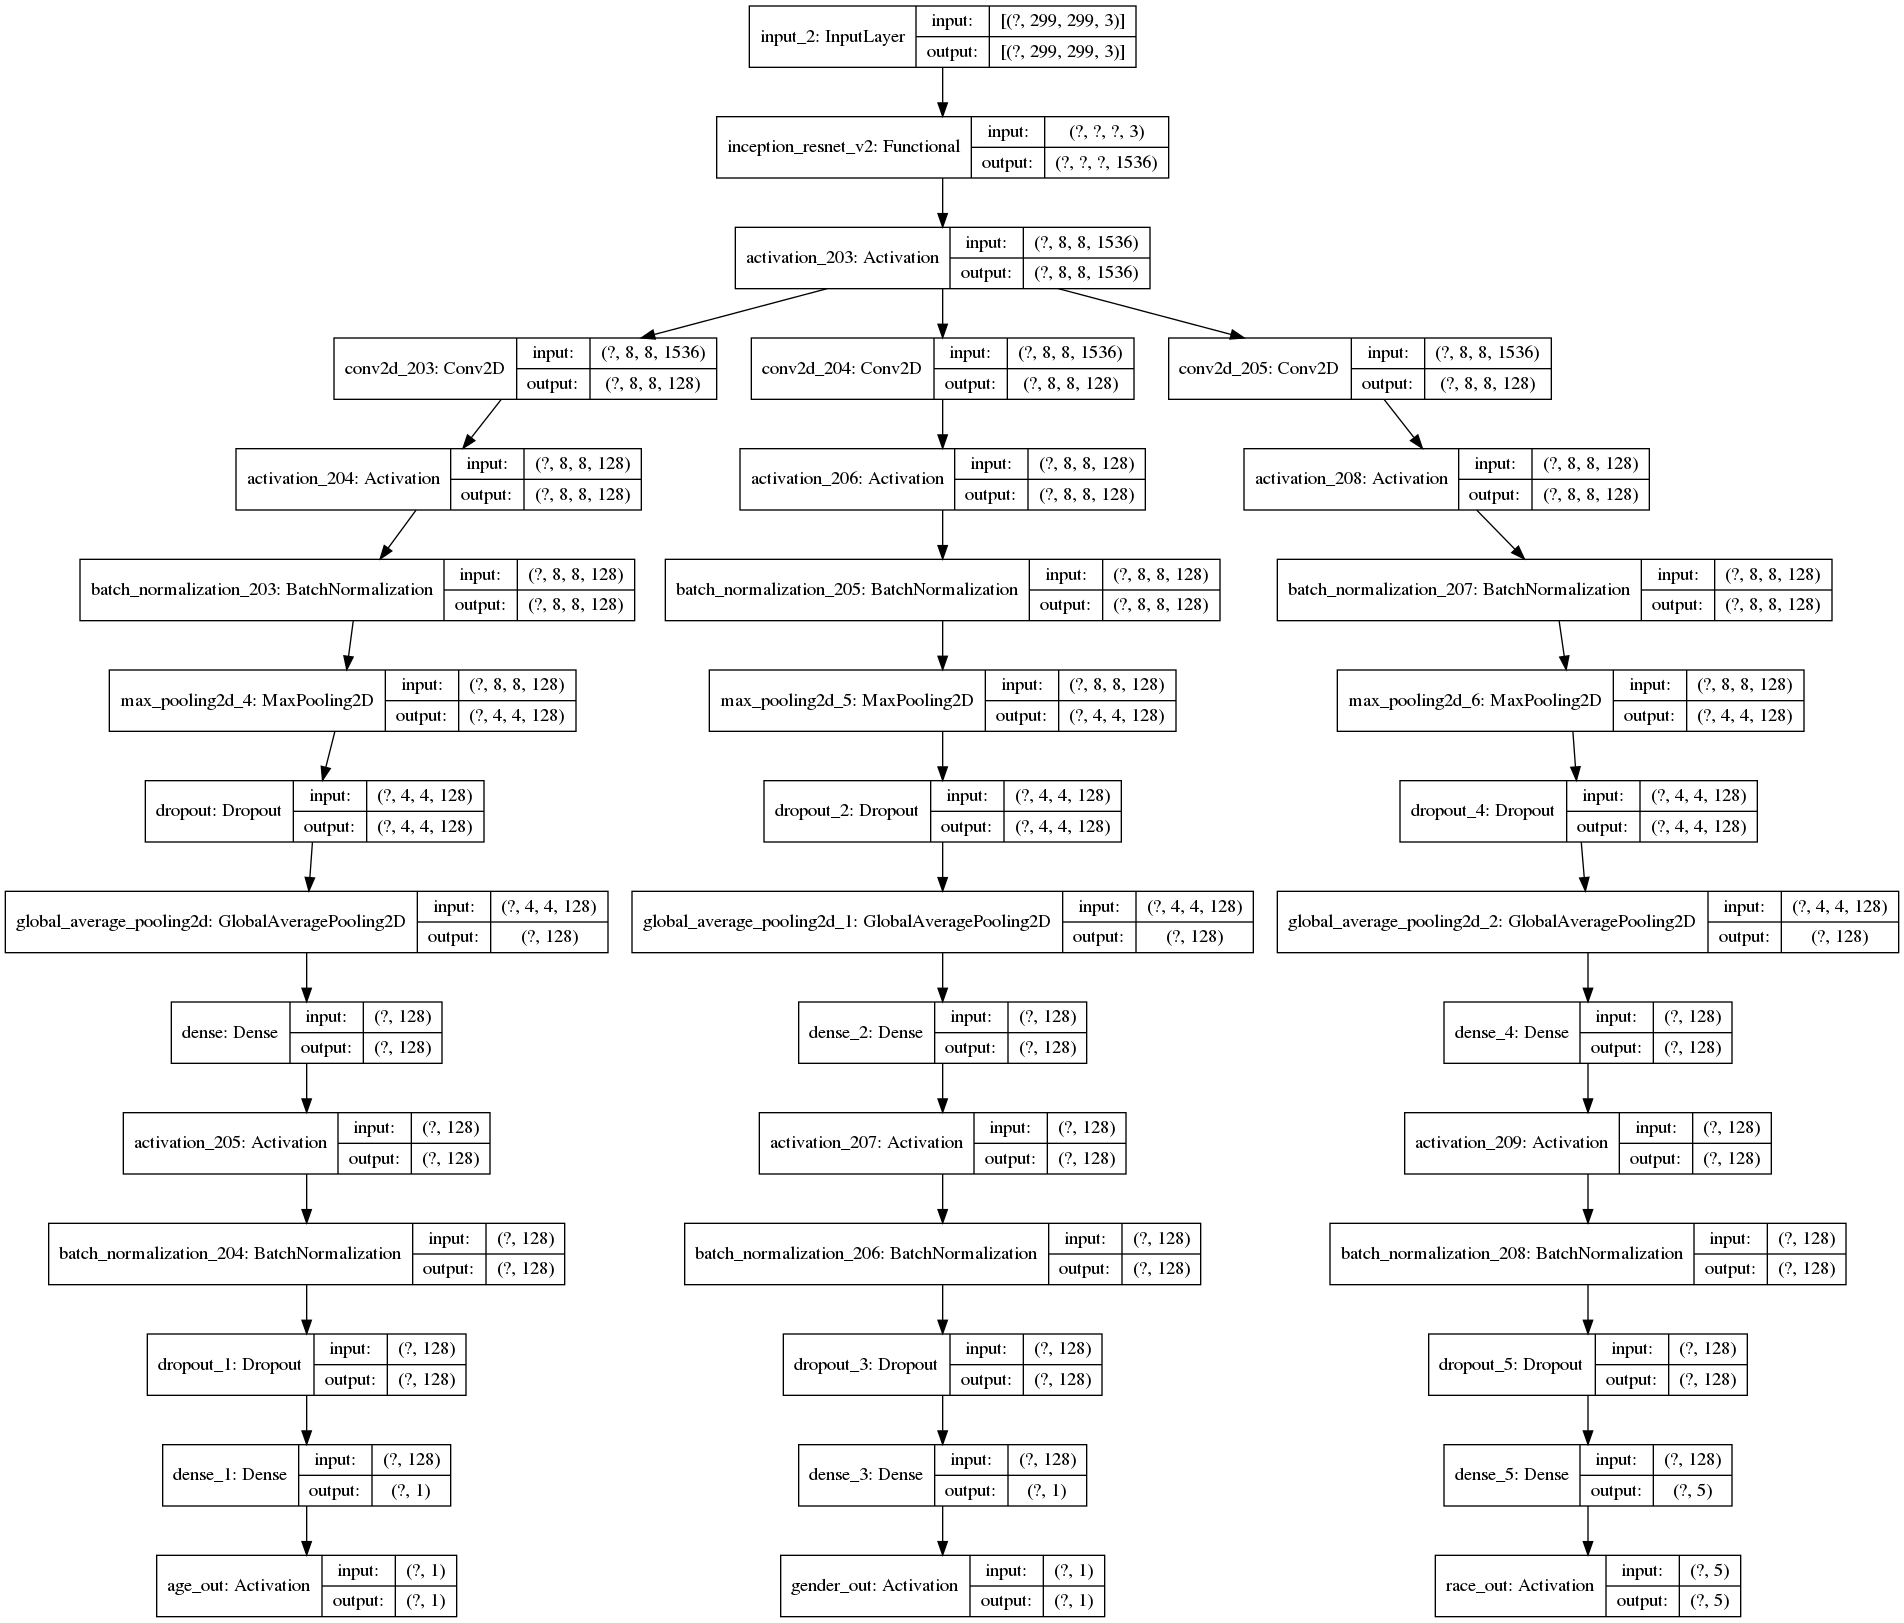

In [16]:
inputs = tf.keras.Input(shape=(299, 299, 3))
x = base_model(inputs, training=False)
print(x)
x = tf.keras.layers.Activation('relu')(x)
#AGE
age_base=create_model_mid_layer(x,'linear','age_out',1)    
age_model = tf.keras.models.Model(inputs, age_base)

#Gender
gender_base=create_model_mid_layer(x,'sigmoid','gender_out',1)    
gender_model = tf.keras.models.Model(inputs, gender_base)

#Race
race_base=create_model_mid_layer(x,'softmax','race_out',no_race_classes)    
race_model = tf.keras.models.Model(inputs, race_base)

model = tf.keras.models.Model(inputs, outputs=[age_base, gender_base, race_base])
# model.summary()

tf.keras.utils.plot_model(model,to_file="model.png",
    show_shapes=True,show_layer_names=True,rankdir="TB",expand_nested=False,dpi=96)

In [17]:
trainable_weights(model)

weights: 938
trainable_weights: 30
non_trainable_weights: 908


# transfer learning

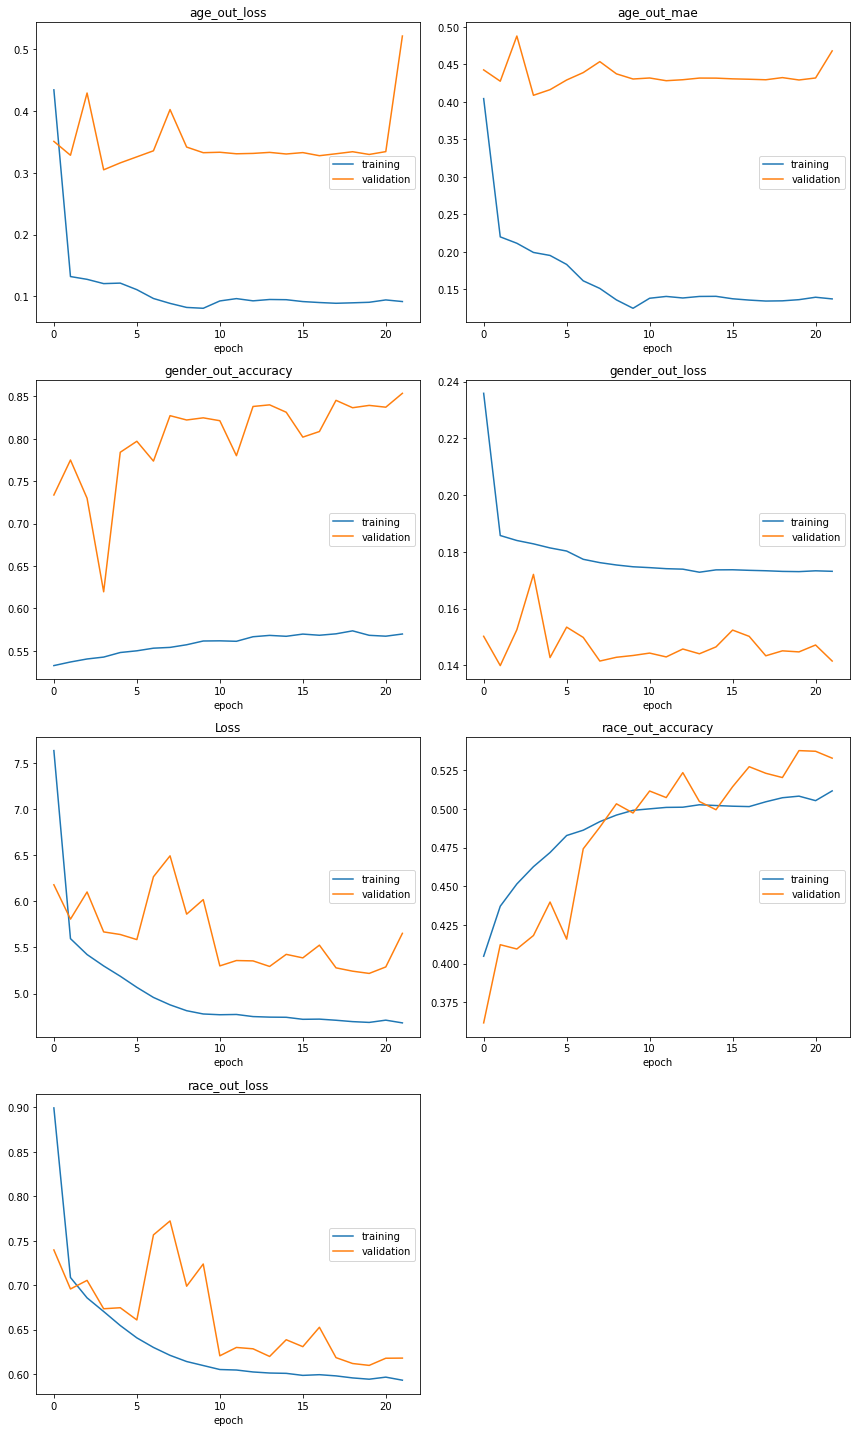

age_out_loss
	training         	 (min:    0.080, max:    0.435, cur:    0.091)
	validation       	 (min:    0.305, max:    0.522, cur:    0.522)
age_out_mae
	training         	 (min:    0.125, max:    0.404, cur:    0.137)
	validation       	 (min:    0.409, max:    0.488, cur:    0.468)
gender_out_accuracy
	training         	 (min:    0.532, max:    0.573, cur:    0.570)
	validation       	 (min:    0.619, max:    0.854, cur:    0.854)
gender_out_loss
	training         	 (min:    0.173, max:    0.236, cur:    0.173)
	validation       	 (min:    0.140, max:    0.172, cur:    0.142)
Loss
	training         	 (min:    4.682, max:    7.636, cur:    4.682)
	validation       	 (min:    5.218, max:    6.494, cur:    5.653)
race_out_accuracy
	training         	 (min:    0.405, max:    0.512, cur:    0.512)
	validation       	 (min:    0.362, max:    0.538, cur:    0.533)
race_out_loss
	training         	 (min:    0.593, max:    0.899, cur:    0.593)
	validation       	 (min:    0.610, max:    

KeyboardInterrupt: 

In [18]:
RUN_NAME = 'model_AGR_inceptionresnetv2_CNN_not_trainable_v3'
model,callbacks=loss_apt_callbacks(0.001,model,cost,metric,loss_weights,RUN_NAME,pa_estop=20,pa_Reduce=5)
hist=train_model(model,callbacks,train,valid,500,32,initial_epoch=0)

In [19]:
plt_loss(hist)

NameError: name 'hist' is not defined

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scattergl(
                    y=history.history['loss'],
                    name='Train'))
fig.add_trace(go.Scattergl(
                    y=history.history['val_loss'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Overall loss',
                  xaxis_title='Epoch',
                  yaxis_title='Loss')
fig.show()

In [ ]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['race_output_acc'],
                    name='Train'))
fig.add_trace(go.Scatter(
                    y=history.history['val_race_output_acc'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Accuracy for race feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()

In [ ]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['gender_output_acc'],
                    name='Train'))
fig.add_trace(go.Scatter(
                    y=history.history['val_gender_output_acc'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Accuracy for gender feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()

In [ ]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scattergl(
                    y=history.history['age_output_mean_absolute_error'],
                    name='Train'))
fig.add_trace(go.Scattergl(
                    y=history.history['val_age_output_mean_absolute_error'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Mean Absolute Error for age feature',
                  xaxis_title='Epoch',
                  yaxis_title='Mean Absolute Error')
fig.show()


# Fine-tuning

In [18]:
base_model.trainable = True
trainable_weights(model)

weights: 938
trainable_weights: 518
non_trainable_weights: 420


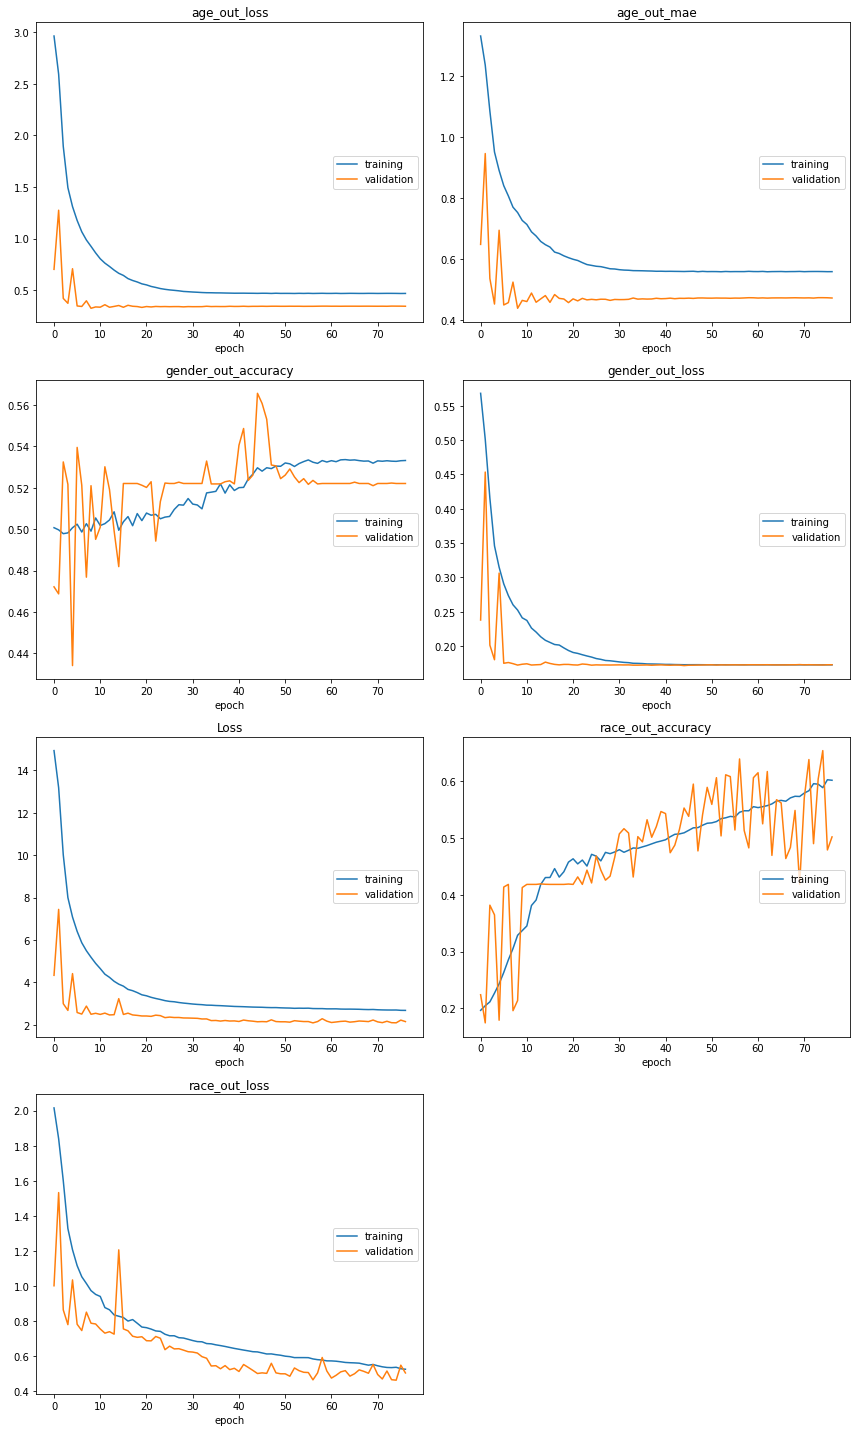

age_out_loss
	training         	 (min:    0.468, max:    2.962, cur:    0.469)
	validation       	 (min:    0.325, max:    1.275, cur:    0.345)
age_out_mae
	training         	 (min:    0.559, max:    1.332, cur:    0.560)
	validation       	 (min:    0.439, max:    0.947, cur:    0.473)
gender_out_accuracy
	training         	 (min:    0.498, max:    0.534, cur:    0.533)
	validation       	 (min:    0.434, max:    0.566, cur:    0.522)
gender_out_loss
	training         	 (min:    0.173, max:    0.568, cur:    0.173)
	validation       	 (min:    0.172, max:    0.453, cur:    0.173)
Loss
	training         	 (min:    2.682, max:   14.930, cur:    2.682)
	validation       	 (min:    2.093, max:    7.444, cur:    2.154)
race_out_accuracy
	training         	 (min:    0.197, max:    0.602, cur:    0.601)
	validation       	 (min:    0.175, max:    0.653, cur:    0.502)
race_out_loss
	training         	 (min:    0.527, max:    2.016, cur:    0.527)
	validation       	 (min:    0.464, max:    

In [19]:
RUN_NAME = 'model_AGR_inceptionresnetv2_CNN_trainable_v3'
model,callbacks=loss_apt_callbacks(1e-5,model,cost,metric,loss_weights,RUN_NAME,pa_estop=20,pa_Reduce=23)
hist=train_model(model,callbacks,train,valid,500,32,initial_epoch=0)

dict_keys(['loss', 'age_out_loss', 'gender_out_loss', 'race_out_loss', 'age_out_mae', 'gender_out_accuracy', 'race_out_accuracy', 'val_loss', 'val_age_out_loss', 'val_gender_out_loss', 'val_race_out_loss', 'val_age_out_mae', 'val_gender_out_accuracy', 'val_race_out_accuracy', 'lr'])


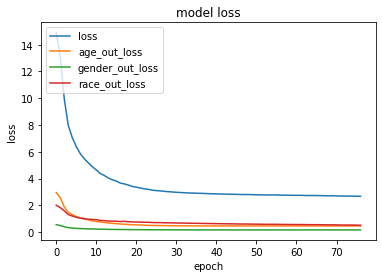

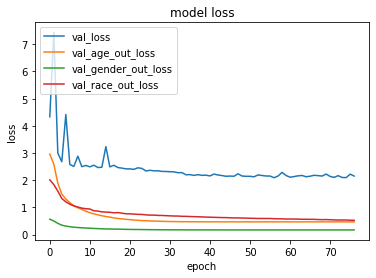

In [20]:
plt_loss(hist)

# function evaluate

In [ ]:
def evaluate(RUN_NAME):
    print('load models = {}.h5'.format(RUN_NAME))
    batch_size = 32
    valid_set = genv(valid, batch_size = batch_size)
    model = tf.keras.models.load_model('../logs/models/{}.h5'.format(RUN_NAME))
    score = model.evaluate(valid_set)
    return score


ev('model_AGR_Xception_CNN_not_trainable_v2')

In [60]:
import multiprocessing
servers={'emotion_cutface':'5021','emotion':'5022'}

def worker(key,val, return_dict):
    '''worker function'''
    print (str(key) + ' represent!')
    return_dict[key] = servers


if __name__ == '__main__':
    manager = multiprocessing.Manager()
    return_dict = manager.dict()
    jobs = []
    for key, val in servers.items():
        p = multiprocessing.Process(target=worker, args=(key,val,return_dict))
        jobs.append(p)
        p.start()

    for proc in jobs:
        proc.join()
    print (return_dict)

emotion_cutface represent!
emotion represent!
{'emotion_cutface': {'emotion_cutface': '5021', 'emotion': '5022'}, 'emotion': {'emotion_cutface': '5021', 'emotion': '5022'}}


In [62]:
eee=return_dict.keys()

In [63]:
eee[0]

'emotion_cutface'